In [3]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Dict, Optional, cast
from torch import Tensor
from collections import OrderedDict 
from torchvision.models.resnet import *
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet50_Weights

/Users/sid/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/sid/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <08E12B12-6183-307E-BDA0-374FA8EBA2C9> /Users/sid/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <408F81C0-C6C8-33EF-B02E-B683F7178A71> /Users/sid/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
class IntResNet(ResNet):
    def __init__(self,output_layer,*args):
        self.output_layer = output_layer
        super().__init__(*args)
        
        self._layers = []
        for l in list(self._modules.keys()):
            self._layers.append(l)
            if l == output_layer:
                break
        self.layers = OrderedDict(zip(self._layers,[getattr(self,l) for l in self._layers]))

    def _forward_impl(self, x):
        for l in self._layers:
            x = self.layers[l](x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [59]:
import numpy as np

In [135]:
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
from numpy import asarray



def get_image(path):
    img = Image.open(path)
    #img.show()
    rgbImg = img.convert("RGB")
    transform = transforms.Compose([            #[1]
    transforms.Resize(256),                    #[2]
    transforms.CenterCrop(224),                #[3]
    transforms.ToTensor(),                     #[4]
    transforms.Normalize(                      #[5]
    mean=[0.485, 0.456, 0.406],                #[6]
    std=[0.229, 0.224, 0.225]                  #[7]
    )])
    img_t = transform(rgbImg)
    batch_t = torch.unsqueeze(img_t, 0)
    transform_RGB = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224)
    ])
    
    rgbImg = np.asarray(transform_RGB(rgbImg))/255

    return batch_t, rgbImg

In [36]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 14.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached torch-2.0.1-cp39-none-macosx_10_9_x86_64.whl (143.4 MB)
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=2286f09ea639f088a7ad7bdeacc6a8dca7b53c807af81dee3adca432ac446517
  Stored in directory: /Users/sid/Library/Caches/pip/wheels/5b/d7/f5/363ec51afcc6b5dd60bd123bdf06c0189221c6505624b5c35a
Successfully built grad-cam
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1


In [37]:

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [1]:
import os
from os import listdir

images = []

for imge in listdir("/Users/sid/Desktop/MML/CoVA dataset/imgs"):
    images.append(imge)


In [38]:
with open('imagenet_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]



In [25]:
from torchvision import models
import torch
resnet = models.resnet101(pretrained=True)
resnet.eval()
 


/Users/sid/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sid/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /Users/sid/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [102]:
target_layers = [resnet.layer4[-1]]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=resnet, target_layers=target_layers)

In [143]:

print(len(images))
print(50*154)

7740
7700


In [144]:
from tqdm import tqdm
predLabels = []
for i in tqdm(range(0, len(images), 50)):
            
            img, rgb = get_image("/Users/sid/Desktop/MML/CoVA dataset/imgs/"+images[i])
            out = resnet(img)
 
# Forth, print the top 5 classes predicted by the model
            _, indices = torch.sort(out, descending=True)
            percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
            pred = [(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]
            predLabels.append((images[i], pred))
            grayscale_cam = cam(input_tensor=img, targets=None)
            grayscale_cam = grayscale_cam[0, :]
            # j = transform(img)
            # j.show()
            #print(rgb.shape, grayscale_cam.shape)
            visualization = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)
            visual = Image.fromarray(visualization)
            visual.save("/Users/sid/Desktop/MML/GradCam output/"+images[i])
            


100%|██████████| 155/155 [05:22<00:00,  2.08s/it]


In [151]:
len(predLabels)

155

In [150]:
print(predLabels)


[['3975.png'
  list([("916: 'web site, website, internet site, site',", 99.96766662597656), ("664: 'monitor',", 0.00825130008161068), ("549: 'envelope',", 0.007796493358910084), ("782: 'screen, CRT screen',", 0.007609665859490633), ("681: 'notebook, notebook computer',", 0.0018094012048095465)])]
 ['8607.png'
  list([("916: 'web site, website, internet site, site',", 99.99897766113281), ("922: 'menu',", 0.00023870746372267604), ("549: 'envelope',", 0.00019112977315671742), ("664: 'monitor',", 0.00015413302753586322), ("782: 'screen, CRT screen',", 0.00014226020721253008)])]
 ['14153.png'
  list([("916: 'web site, website, internet site, site',", 99.65416717529297), ("549: 'envelope',", 0.28072234988212585), ("681: 'notebook, notebook computer',", 0.008533371612429619), ("782: 'screen, CRT screen',", 0.008052833378314972), ("527: 'desktop computer',", 0.005369651131331921)])]
 ['9874.png'
  list([("916: 'web site, website, internet site, site',", 99.92816925048828), ("664: 'monitor',", 

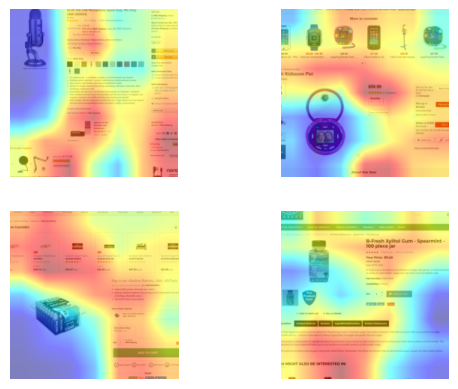

In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageChops


Image1 = cv2.cvtColor(cv2.imread('GradCam output/781.png'), cv2.COLOR_BGR2RGB)
Image2 = cv2.cvtColor(cv2.imread('GradCam output/1322.png'), cv2.COLOR_BGR2RGB)
Image3 = cv2.cvtColor(cv2.imread('GradCam output/1438.png'), cv2.COLOR_BGR2RGB)
Image4 = cv2.cvtColor(cv2.imread('GradCam output/1457.png') , cv2.COLOR_BGR2RGB)
Image5 = cv2.cvtColor(cv2.imread('GradCam output/2354.png'), cv2.COLOR_BGR2RGB) 
Image6 = cv2.cvtColor(cv2.imread('GradCam output/4316.png') , cv2.COLOR_BGR2RGB)
Image7 = cv2.cvtColor(cv2.imread('GradCam output/5692.png'), cv2.COLOR_BGR2RGB) 
Image8 =cv2.cvtColor(cv2.imread('GradCam output/9122.png') , cv2.COLOR_BGR2RGB)

rows, cols = 2, 2
plt.subplot(rows, cols, 1)
plt.imshow(Image2) 
plt.axis('off')
# plt.title("Figure 2")
plt.subplot(rows, cols, 2)
plt.imshow(Image3) 
plt.axis('off')
# plt.title("Figure 3")
plt.subplot(rows, cols, 3)
plt.imshow(Image5) 
plt.axis('off')
# plt.title("Figure 5")

plt.subplot(rows, cols, 4)
plt.imshow(Image7) 
plt.axis('off')
# plt.title("Figure 7")
# plt.subplot(rows, cols, 8)
# plt.imshow(Image8)
# plt.axis('off') 
# plt.title("Figure 8")

plt.show()